## Importing Libraries

In [1]:
from glob import glob
import tensorflow as tf
import keras
from keras import layers
import pandas as pd
import numpy as np
import os
import warnings
from itertools import chain
import pyarabic.araby as araby

os.environ["KERAS_BACKEND"] = "tensorflow"
warnings.filterwarnings("ignore")

2024-07-07 23:33:50.707601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 23:33:50.707709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 23:33:50.853511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Read the dataset

In [2]:
work_dir = "/kaggle/input"
output_dir = "/kaggle/working/outputs"

train_csv_path = work_dir + "/mtc-asr-cleaned-data/output/train_f.csv"
train_audio_path = work_dir + "/mtc-asr-cleaned-data"


# Reading the CSV files into DataFrames
train_df = pd.read_csv(train_csv_path).iloc[:, 1:]

# train_df = train_df.head(10)

audio_files_train = train_df[["path(clean)", "transcript"]]

# correct paths
audio_files_train['path'] = audio_files_train['path(clean)'].apply(lambda path: train_audio_path + '/' + '/'.join(os.path.abspath(path).split('/')[-3:]))

In [3]:
audio_files_train.count()

path(clean)    63386
transcript     63350
path           63386
dtype: int64

In [4]:
# remove nan values
# Drop rows with NaN values in the "transcript" column
audio_files_train.dropna(inplace=True)

# Function to remove diacritical marks from Arabic text
def remove_diacritics(text):
    return araby.strip_tashkeel(text)

audio_files_train["transcript"] = audio_files_train["transcript"].apply(remove_diacritics)

In [5]:
audio_files_train.head()

,path(clean),transcript,path
0,../working/cleaned/train/train_sample_0.wav,إنها عار الوقت اللي كانت بتتعامل أخويا الولد ا...,/kaggle/input/mtc-asr-cleaned-data/cleaned/tra...
1,../working/cleaned/train/train_sample_1.wav,فأكيد ربنا عوضهم خير الراجل بيبقى ليه إختيارات...,/kaggle/input/mtc-asr-cleaned-data/cleaned/tra...
2,../working/cleaned/train/train_sample_2.wav,زي دول كتيره بنشوفها النهارده العالم وأصبحت ال...,/kaggle/input/mtc-asr-cleaned-data/cleaned/tra...
3,../working/cleaned/train/train_sample_3.wav,يعني مين اللي بيحط شروطها يعني شايفه إني متوافقه,/kaggle/input/mtc-asr-cleaned-data/cleaned/tra...
4,../working/cleaned/train/train_sample_4.wav,والله الموضوع مش كليب خلي بالك أغنيه الموضوع م...,/kaggle/input/mtc-asr-cleaned-data/cleaned/tra...


In [6]:
# Create a dictionary mapping id to transcript text
id_to_text = {}
for index, row in audio_files_train.iterrows():
    id = str(row['path'])  # Assuming 'id' is the column name in your CSV
    text = str(row['transcript'])  # Assuming 'transcript' is the column name in your CSV
    id_to_text[id] = text


def get_data(audio_files_df, id_to_text, maxlen=50):
    """returns mapping of audio paths and transcription texts"""
    data = []
    for index, row in audio_files_df.iterrows():
        audio_path = str(row['path'])  # Assuming 'path' is the column name in your CSV
        id = audio_path  # Extract id from audio file path
        if id in id_to_text and len(id_to_text[id]) < maxlen:
            data.append({"audio": audio_path, "text": id_to_text[id]})
    return data

## Preprocess the dataset

In [7]:
# Extract all unique characters from transcripts
transcripts = audio_files_train["transcript"].dropna().tolist()

# Use itertools.chain to flatten the list of transcripts and create a set of unique characters
all_chars = set(chain.from_iterable(transcripts))

# Convert the set to a list
all_chars = list(all_chars)
all_chars

all_chars = sorted(all_chars, key=lambda c: ord(c))
print(all_chars)

[' ', '،', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', '١', 'ٱ', 'چ', 'ڨ']


In [8]:
# List of characters to count
import matplotlib.pyplot as plt

characters = all_chars

# Initialize a dictionary to store character counts
character_counts = {}

# Iterate over each character and count its occurrences
for char in characters:
    # Count the occurrences of the character in the "transcript" column
    count = audio_files_train['transcript'].str.count(char).sum()
    character_counts[char] = count
    
character_counts

{' ': 582864,
 '،': 2,
 'ء': 5966,
 'آ': 824,
 'أ': 59647,
 'ؤ': 2080,
 'إ': 33676,
 'ئ': 5259,
 'ا': 402839,
 'ب': 131980,
 'ة': 12330,
 'ت': 154804,
 'ث': 7825,
 'ج': 47642,
 'ح': 69347,
 'خ': 27658,
 'د': 109806,
 'ذ': 5552,
 'ر': 127067,
 'ز': 23305,
 'س': 68904,
 'ش': 53966,
 'ص': 32455,
 'ض': 19127,
 'ط': 29368,
 'ظ': 5854,
 'ع': 111222,
 'غ': 9427,
 'ف': 60391,
 'ق': 68482,
 'ك': 81740,
 'ل': 314033,
 'م': 179836,
 'ن': 163954,
 'ه': 177688,
 'و': 139364,
 'ى': 13835,
 'ي': 263368,
 '١': 2,
 'ٱ': 1,
 'چ': 1,
 'ڨ': 3}

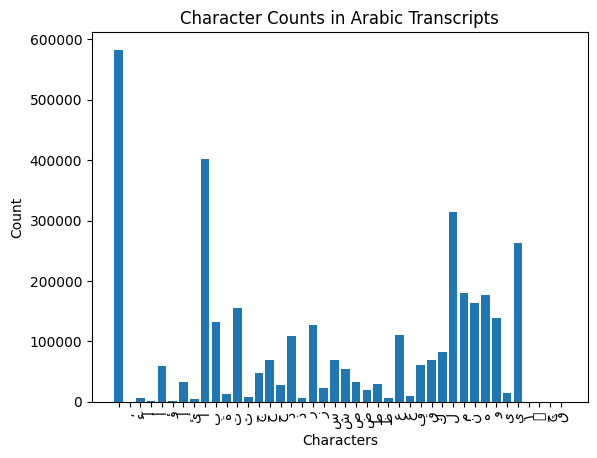

In [9]:
# Create bar chart
plt.bar(character_counts.keys(), character_counts.values())
plt.xlabel('Characters')
plt.ylabel('Count')
plt.title('Character Counts in Arabic Transcripts')
plt.xticks(rotation=90)
plt.show()

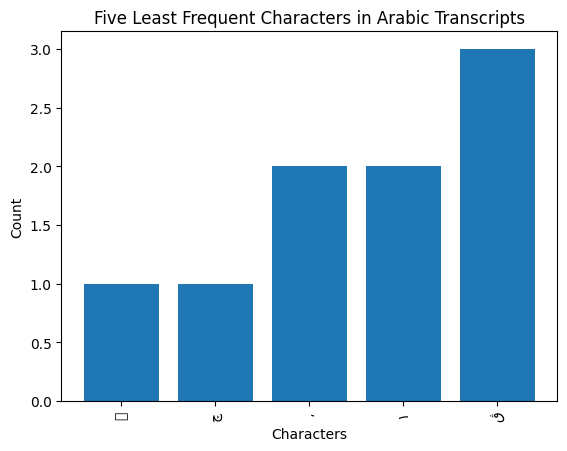

In [10]:
# Sort the character counts dictionary by value in ascending order
sorted_counts = sorted(character_counts.items(), key=lambda x: x[1])

# Get the five least frequent characters and their counts
least_frequent = dict(sorted_counts[:5])

# Create bar chart for the least frequent characters
plt.bar(least_frequent.keys(), least_frequent.values())
plt.xlabel('Characters')
plt.ylabel('Count')
plt.title('Five Least Frequent Characters in Arabic Transcripts')
plt.xticks(rotation=90)
plt.show()

In [11]:
characters = [char for char in characters if char not in least_frequent]
print(characters)

[' ', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']


In [12]:
# # Function to filter out characters not in the vocab
# def filter_characters(text):
#     filtered_text = ''.join([char for char in text if char in characters])
#     return filtered_text

# # Apply the function to the 'transcript' column
# audio_files_train['transcript'] = audio_files_train['transcript'].apply(filter_characters)

In [13]:
class VectorizeChar:
    def __init__(self, max_len=50):
        # Arabic characters and special tokens
        self.vocab = ["-", "#", "<", ">"] + characters
        self.max_len = max_len
        self.char_to_idx = {ch: i for i, ch in enumerate(self.vocab)}

    def __call__(self, text):
        text = text[:self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab



max_target_len = 200  # all transcripts in out data are < 200 characters
data = get_data(audio_files_train, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))

vocab size 41


In [14]:
def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path, fixed_length=48000):
    # Read audio file
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    
    # Pad or truncate audio to fixed length
    audio = tf.cond(
        tf.shape(audio)[0] < fixed_length,
        lambda: tf.pad(audio, [[0, fixed_length - tf.shape(audio)[0]]]),
        lambda: tf.slice(audio, [0], [fixed_length])
    )
    
    # Apply a window function to reduce spectral leakage
    window = tf.signal.hann_window(200)
    
    # Compute the STFT
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256, window_fn=lambda frame_length, dtype: window)
    
    # Convert to magnitude spectrogram and apply power-law compression
    magnitude_spectrograms = tf.abs(stfts)
    power_spectrograms = tf.math.pow(magnitude_spectrograms, 0.5)
    
    # Normalize the spectrogram
    mean, variance = tf.nn.moments(power_spectrograms, axes=[0, 1], keepdims=True)
    normalized_spectrograms = (power_spectrograms - mean) / tf.sqrt(variance + 1e-10)
    
    # Apply noise reduction (simple spectral gating)
    noise_reduction_factor = 0.05
    threshold = tf.reduce_mean(normalized_spectrograms) * noise_reduction_factor
    noise_reduced_spectrograms = tf.where(normalized_spectrograms < threshold, tf.zeros_like(normalized_spectrograms), normalized_spectrograms)
    
    return noise_reduced_spectrograms

# Example usage
# spectrogram = path_to_audio('path_to_audio_file.wav')




def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(path_to_audio, num_parallel_calls=tf.data.AUTOTUNE)
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


split = int(len(data) * 0.99)
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)

## Define the Transformer Input Layer

When processing past target tokens for the decoder, we compute the sum of
position embeddings and token embeddings.

When processing audio features, we apply convolutional layers to downsample
them (via convolution strides) and process local relationships.

In [15]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_vocab": self.num_vocab,
            "num_hid": self.num_hid,
            "maxlen": self.maxlen,
        })
        return config

class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_hid": self.num_hid,
            "maxlen": self.maxlen,
        })
        return config

## Transformer Encoder Layer

In [16]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_hid": self.num_hid,
            "num_head": self.num_head,
            "num_feed_forward": self.num_feed_forward,
        })
        return config

## Transformer Decoder Layer

In [17]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_hid": self.num_hid,
            "num_head": self.num_head,
            "num_feed_forward": self.num_feed_forward,
        })
        return config

## Complete the Transformer model

Our model takes audio spectrograms as inputs and predicts a sequence of characters.
During training, we give the decoder the target character sequence shifted to the left
as input. During inference, the decoder uses its own past predictions to predict the
next token.

In [18]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
        **kwargs,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes
        
        # Add these lines to store the parameters as instance variables
        self.num_hid = num_hid
        self.num_head = num_head
        self.num_feed_forward = num_feed_forward
        self.source_maxlen = source_maxlen

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compute_loss(None, one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compute_loss(None, one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_hid": self.num_hid,
            "num_head": self.num_head,
            "num_feed_forward": self.num_feed_forward,
            "source_maxlen": self.source_maxlen,
            "target_maxlen": self.target_maxlen,
            "num_layers_enc": self.num_layers_enc,
            "num_layers_dec": self.num_layers_dec,
            "num_classes": self.num_classes,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Callbacks to display predictions

In [19]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")


## Learning rate schedule

In [20]:
@keras.saving.register_keras_serializable()
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """linear warm up - linear decay"""
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / self.decay_epochs,
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        epoch = tf.cast(epoch, "float32")
        return self.calculate_lr(epoch)

    def get_config(self):
        return {
            "init_lr": self.init_lr,
            "lr_after_warmup": self.lr_after_warmup,
            "final_lr": self.final_lr,
            "warmup_epochs": self.warmup_epochs,
            "decay_epochs": self.decay_epochs,
            "steps_per_epoch": self.steps_per_epoch,
        }
    
#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)

## Create & train the end-to-end model

In [21]:
batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=len(vectorizer.get_vocabulary()),
)

loss_fn = keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)
optimizer = keras.optimizers.Adam(learning_rate, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [22]:
history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb], epochs=151)

Epoch 1/151
  2/980 ━━━━━━━━━━━━━━━━━━━━ 1:17 79ms/step - loss: 1.4133  

I0000 00:00:1720395328.470797      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720395328.513929      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 1.0018

W0000 00:00:1720395515.924388      65 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


target:     <إدونا الثقافه التربيه الثقافيه الفنيه بتاعة الجمهور الناس اللي ممكن تعمل ده إم عندك أهو>
prediction: <اللي اللي الي الي الي الي الي الي ال الي الي الي الي الي الي اللم الل الي الي اللي الي الي م الي الم الم الم الي مل اليعلي الم الي اليه الي الم الي الم اللي الي اله الي الي المالمله الي الينالي الي ا

target:     <حطها جنب وخلاص تخليها خليها يلا إتفقنا شوف>
prediction: <اللي اللي الي الي الي الي الي الي ال الي الي الي الي الي الي اللم الل الي الي اللي الي الي م الي الم الم الم الي مل اليعلي الم الي اليه الي الم الي الم اللي الي اله الي الي المالمله الي الينالي الي ا

target:     <أه بابا أمير كراره مش بتاع سبوبه أعمل حاجه محترمه وكبيره معملش>
prediction: <اللي اللي الي الي الي الي الي الي ال الي الي الي الي الي الي اللم الل الي الي اللي الي الي م الي الم الم الم الي مل اليعلي الم الي اليه الي الم الي الم اللي الي اله الي الي المالمله الي الينالي الي ا

target:     <كأجيال جايه بعدهم شاء الله أجيال تانه تانيه كتير برحب بيه زميل العزيز محمد الجباس الإسماعيليه محمد صلا>
predi

In [23]:
# Save the model
os.makedirs(output_dir+"/models", exist_ok=True)
model_save_path = output_dir + "/models/"+ 'model.keras'
model.save(model_save_path, save_format='keras')

# Save the weights
weights_save_path = output_dir + "/models/"+ 'model.weights.h5'
model.save_weights(weights_save_path)

In [24]:
# Load the model
loaded_model = keras.models.load_model(model_save_path, custom_objects={
    'Transformer': Transformer,
})

In [25]:
def test_model(model, ds, idx_to_token, target_start_token_idx=2, target_end_token_idx=3):
    # Create a test batch from the dataset
    test_batch = next(iter(ds))

    # Extract batch components
    source = test_batch["source"]
    target = test_batch["target"].numpy()

    # Evaluate the model
    results = model.evaluate(ds)
    print(f"Test loss: {results}")

    # Perform inference and display outputs
    bs = tf.shape(source)[0]
    preds = model.generate(source, target_start_token_idx)
    preds = preds.numpy()
    for i in range(bs):
        target_text = "".join([idx_to_token[_] for _ in target[i, :]])
        prediction = ""
        for idx in preds[i, :]:
            prediction += idx_to_token[idx]
            if idx == target_end_token_idx:
                break
        print(f"target:     {target_text.replace('-', '')}")
        print(f"prediction: {prediction}\n")

    return results

In [26]:
idx_to_token = vectorizer.get_vocabulary()

# Assume ds is your dataset and idx_to_token is your list of vocabulary tokens
test_results = test_model(model, val_ds, idx_to_token)

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3522
Test loss: 0.35649991035461426
target:     <إدونا الثقافه التربيه الثقافيه الفنيه بتاعة الجمهور الناس اللي ممكن تعمل ده إم عندك أهو>
prediction: <إدولانفس القافوا الثر قافوا الفنيه بتاع بطريق الدولاربيه فهمي بتاع فينه مش دنيا بيعمل فين>

target:     <حطها جنب وخلاص تخليها خليها يلا إتفقنا شوف>
prediction: <عبد عنده خلاص تجنر بالخليها يلان داخليهاه أحمد حمد لله>

target:     <أه بابا أمير كراره مش بتاع سبوبه أعمل حاجه محترمه وكبيره معملش>
prediction: <أه ببا أمير وبتدي حاجات حاجه وكل الشنايه والليليليليليليليلي>

target:     <كأجيال جايه بعدهم شاء الله أجيال تانه تانيه كتير برحب بيه زميل العزيز محمد الجباس الإسماعيليه محمد صلا>
prediction: <كأجيال جايه بعدهم شاء الله عدون ممن شاء جايه بيها بيقول العسكر تانيه ومحمد النهارده موجاه>

